In [1]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Annotation 1 - Save with double frequency
VAD = "VADresult.csv"
F0  = "F0result.csv"

In [3]:
vocal = []
notes = []

with open(VAD) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        vocal.append(float(row[0]))

with open(F0) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        notes = row

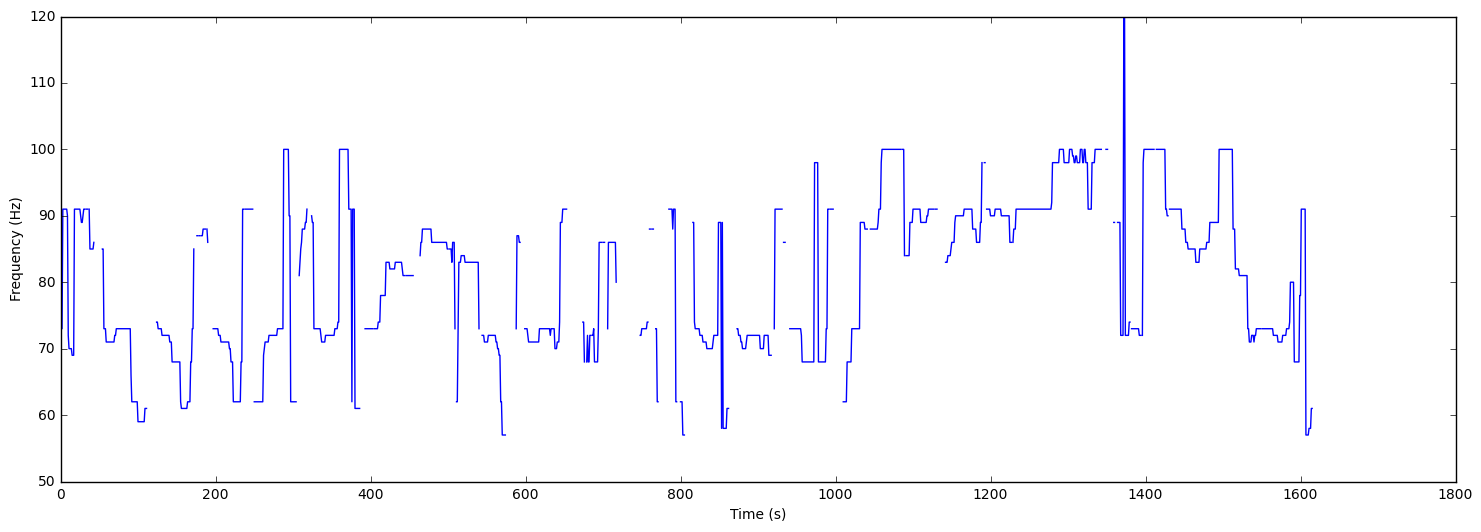

In [4]:
# We have doubled vocal answers
res = []


for j in range(len(notes)):
    res.append(int(vocal[::2][j]*float(notes[j])))
    if res[j] == 0:
        res[j] = None

# Plot melodic line from annotation
plt.figure(figsize=(18,6))
plt.plot(res)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

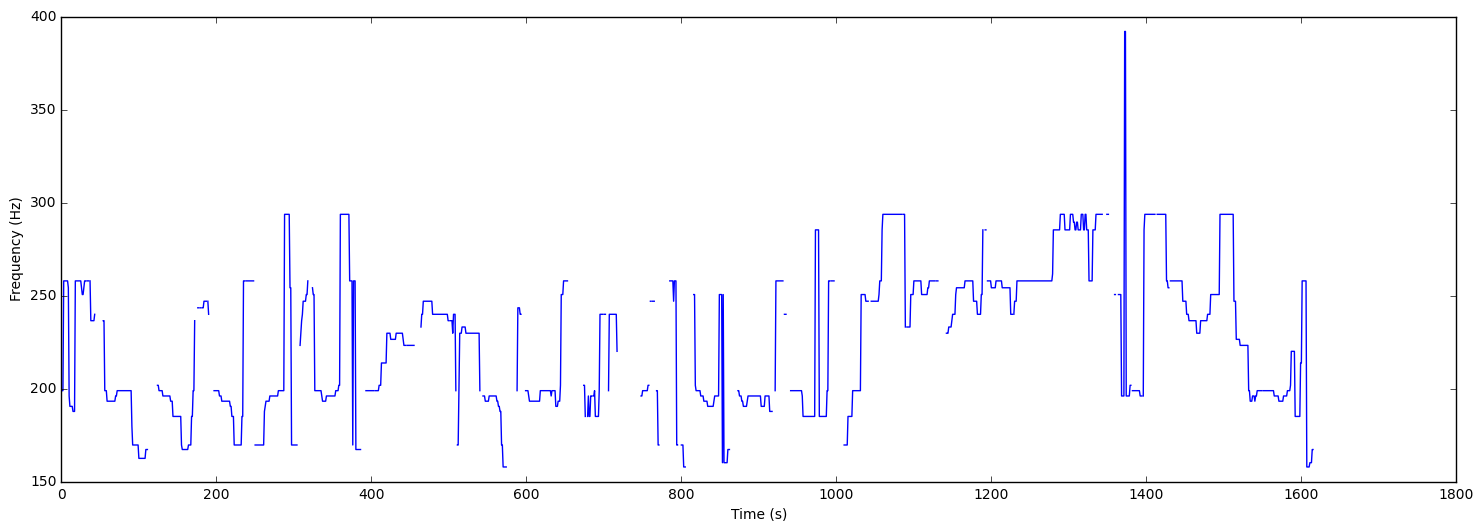

In [5]:
import numpy as np
melodic_line =[]

T1 = np.linspace(0,4, 193)
for note in res:
    if note is None:
        melodic_line.append(None)
    else:
        melodic_line.append(2**(T1[note]+np.log2(69.29)))
    

# Plot melodic line from annotation
plt.figure(figsize=(18,6))
plt.plot(melodic_line)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

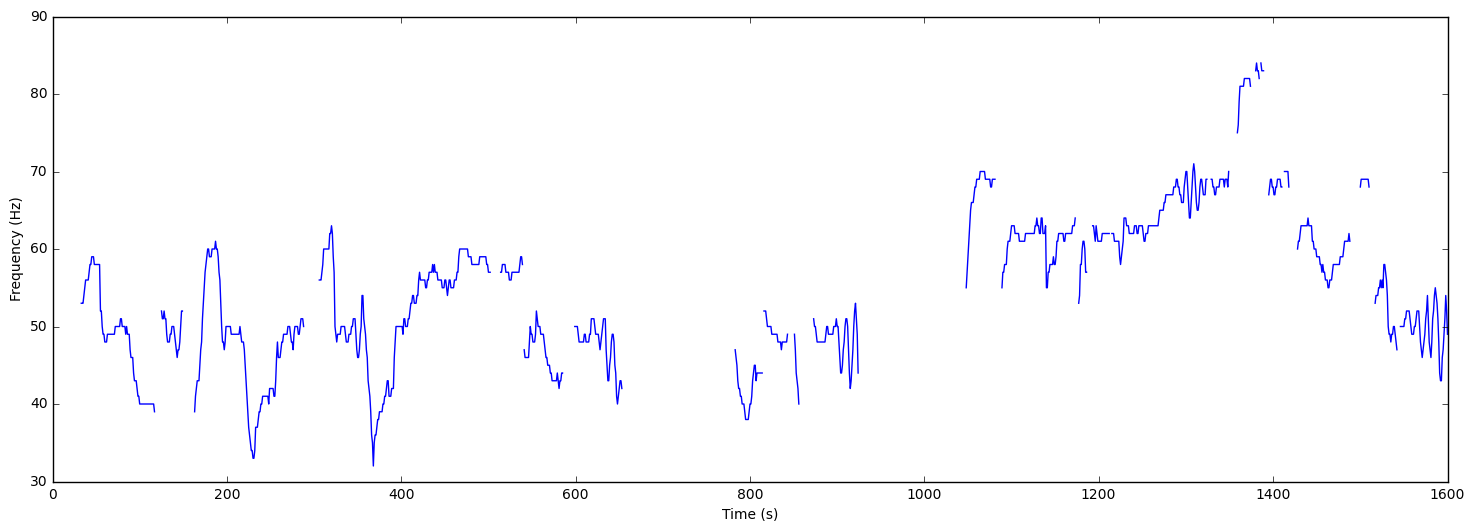

(3241, 1)


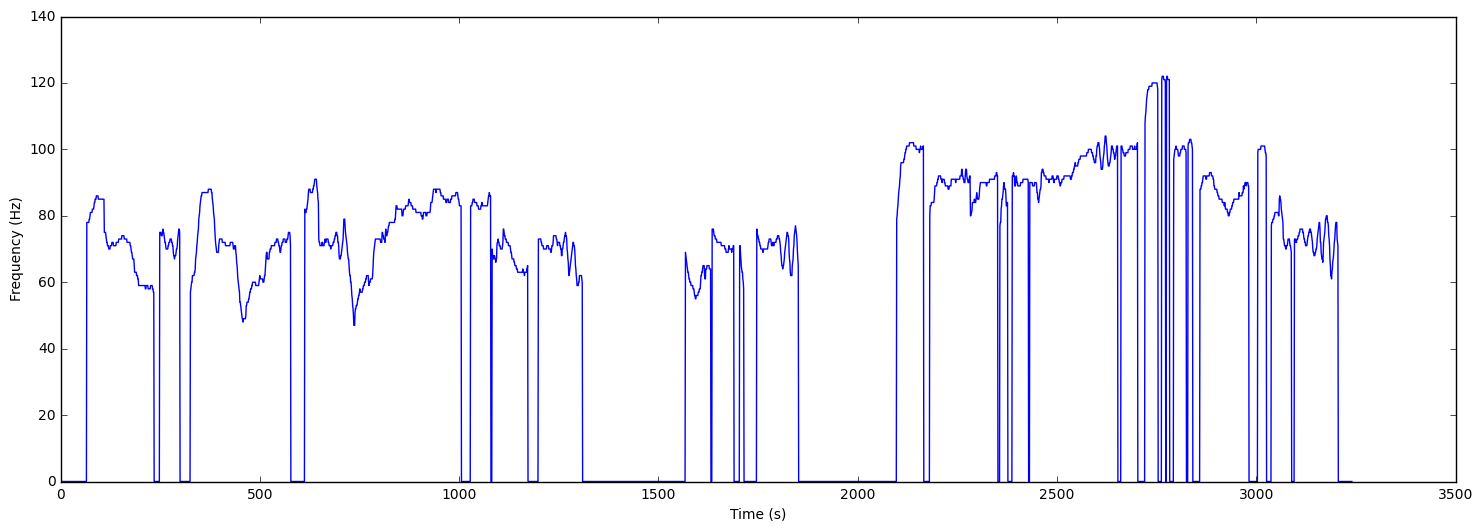

In [6]:
annot = "MusicDelta_Rockabilly_MELODY1.csvlabels.csv"

labels = []

with open(annot) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels.append(float(row[0]))
        
for i in range(len(labels)):
    if labels[i] <= 0:
        labels[i] = None
        
# Plot melodic line from annotation
plt.figure(figsize=(18,6))
plt.plot(labels)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


import pandas as pd
df3=pd.read_csv("MusicDelta_Rockabilly_labels.csv",header=None)
df4=pd.DataFrame.as_matrix(df3)
labels = df4[::2] # Hop size is doubled in features
print (df4.shape)

plt.figure(figsize=(18,6))
plt.plot(df4)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()